## <h3 style="text-align: center;"><b>Classifying Sentiment of Restaurant Reviews </b>

    In this tutorial we will apply the concepts learned in the previous tutorial on a real world task.
    We will use a simple single-layer Neural Network to classify restaurant reviews on Yelp as positive or negative.

In [24]:
%matplotlib inline
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
from collections import defaultdict, Counter, OrderedDict
import torch
import torch.nn as nn
from torchtext.vocab import vocab
from torch.utils.data import DataLoader

In [2]:
# import datasets
yelp = pd.read_csv(r"D:\Huawei Share\Download\reviews_with_splits_lite.csv")

In [3]:
yelp.head()

,rating,review,split
0,negative,terrible place to work for i just heard a stor...,train
1,negative,"hours , minutes total time for an extremely s...",train
2,negative,my less than stellar review is for service . w...,train
3,negative,i m granting one star because there s no way t...,train
4,negative,the food here is mediocre at best . i went aft...,train


We create three partitions of the dataset: one for training, one for validation and one for testing.

In [4]:
train_data = yelp[yelp.split=="train"]
valid_data = yelp[yelp.split=="val"]
test_data = yelp[yelp.split=="test"]

In order to enable Neural Network model to interact with text data, we need to covert the review text into a vector of numbers representing the review.\
We design a pipeline to convert text inputs to vectorized minibatches:
1. The pipeline starts with preprocessed text; each data point is a list of tokens, i.e. words in this example;
1. Using training partition of the dataset we build a vocabulary that coordinates integer-to-token mappings;
2. In the vectorization step, the mapping is applied to each data point to create a vector from a review;
3. Finally, PyTorch's DataLoader will be used to group the vectorized reviews into minibatches for the model.

## <h6 style="text-align: center;"><b>Text cleansing</b>

We define a function to clean the review text from punctuation and special symbols.

In [85]:
def tokenize(text):
    """Removing punctuation and special symbols from review text"""
    
    clean_text = re.sub("[^a-zA-Z]+", " ", text).lower()
    return clean_text.split() # list of tokens

## <h6 style="text-align: center;"><b>Building token to integer mapping</b>

In [86]:
token_counter = Counter()
        
# extract unique words from the dataset
for _, row in train_data.iterrows():
    tokens = tokenize(row.review)
    token_counter.update(tokens)
    
# set a minimum token frequency to restrict infrequent tokens from the Vocabulary
cutoff = 25

# building Vocabulary
sorted_tokens = token_counter.most_common() # list of tuples (token, cnt)
vocabulary = vocab(OrderedDict(sorted_tokens),
                   min_freq=cutoff,
                   specials = ["<unk>"])

# set <unk> index as default index
unk_index = vocabulary["<unk>"]
vocabulary.set_default_index(unk_index)

In [9]:
len(vocabulary)

7497

In [ ]:
[0, 1, 0, 1, 0, 0 , ..., 0] # 7497

In [55]:
[vocabulary[word] for word in "i loved the view".split()]

[3, 540, 1, 1003]

## <h6 style="text-align: center;"><b>Vectorization</b>

The second step: transform a review string into a tensor of numbers.\
In this example we will be using a **collapsed one-hot representation**:\
each review is represented as a binary vector, a vector of 1s and 0s, with length equal to the number of words in the Vocabulary.\
The binary vector has 1 in the index position of those words that are present in that review. 
* First, we iterate through the tokens of a single review and use the token-to-integer mapping to convert each token to its vocabulary index.
* Then, we use these integers to fill with 1s the corresponding index positions inside a zero tensor. 

The resulting binary tensor will serve as a numerical representation for a single review.

In [90]:
def vectorize(review):
    """
    Creates a collapsed one-hot tensor for a single text review.
    
    Args:
        review (str): a text review
    Returns:
        one_hot_tensor (torch.FloatTensor): collapsed one-hot representation of a review
    """
    indexes_list = [vocabulary[token] for token in tokenize(review)]
    one_hot_vector = torch.zeros(len(vocabulary), dtype=torch.float32)
    for token_index in indexes_list:
        one_hot_vector[token_index] = 1
    return one_hot_vector

In [121]:
vectorize("i am a big gelato fan!").nonzero()

tensor([[   3],
        [   5],
        [ 118],
        [ 217],
        [ 518],
        [4686]])

## <h6 style="text-align: center;"><b>Custom Dataset</b>

We create a ReviewsDataset class, that internally converts a single review into a vector representation.\
The class simplifies the access to individual training examples. To build our custom dataset class,\
we must subclass PyTorch's ``Dataset`` class and overwrite its ``__len__`` and ``__getitem__`` methods.

In [92]:
class ReviewsDataset(torch.utils.data.Dataset):
    
    def __init__(self, dataset, vocabulary):
        self.dataset = dataset
        self.vocabulary = vocabulary
        self.label2index = {"positive":0, "negative":1} 
        
        
    def __len__(self):
        return len(self.dataset) # return the size of the dataset
        
    
    def __getitem__(self, index):
        
        # read one labeled pair from dataframe
        row = self.dataset.iloc[index]
        review = row.review
        label = row.rating
        
        # preprocess and vectorize text review
        vectorized_review = vectorize(review)
        
        # map label to integer and convert to float tensor
        target = self.label2index[label]
        
        # return a vectorized inputs-label pair
        return vectorized_review, torch.tensor(target, dtype=torch.float)

In [93]:
train_dataset = ReviewsDataset(train_data, vocabulary)
valid_dataset = ReviewsDataset(valid_data, vocabulary)
test_dataset = ReviewsDataset(test_data, vocabulary)

In [96]:
train_dataset[0]

(tensor([1., 1., 1.,  ..., 0., 0., 0.]), tensor(1.))

## <h6 style="text-align: center;"><b>Data Loader</b>

The final step of the data preparation pipeline is to group vectorized data points into batches.\
We take advantage of PyTorch's ``DataLoader`` class, which expects a ``PyTorch Dataset`` and a ``batch_size`` as its compulsary arguments.

In [97]:
batch_size = 32

train_dataloader = torch.utils.data.DataLoader(train_dataset,
                            batch_size = batch_size,
                            shuffle = True,
                            drop_last = True)

eval_dataloader = torch.utils.data.DataLoader(valid_dataset,
                            batch_size = batch_size,
                            shuffle = False,
                            drop_last = True)

## <h6 style="text-align: center;"><b>Sentiment Classifier</b>

We reimplement the model from the previous tutorial. The Classifier inherits from PyTorch nn.Module.\
A single linear layer projects a feature tensor into a scalar.\
The sigmoid is used as the final activation to convert linear output into a probability value.

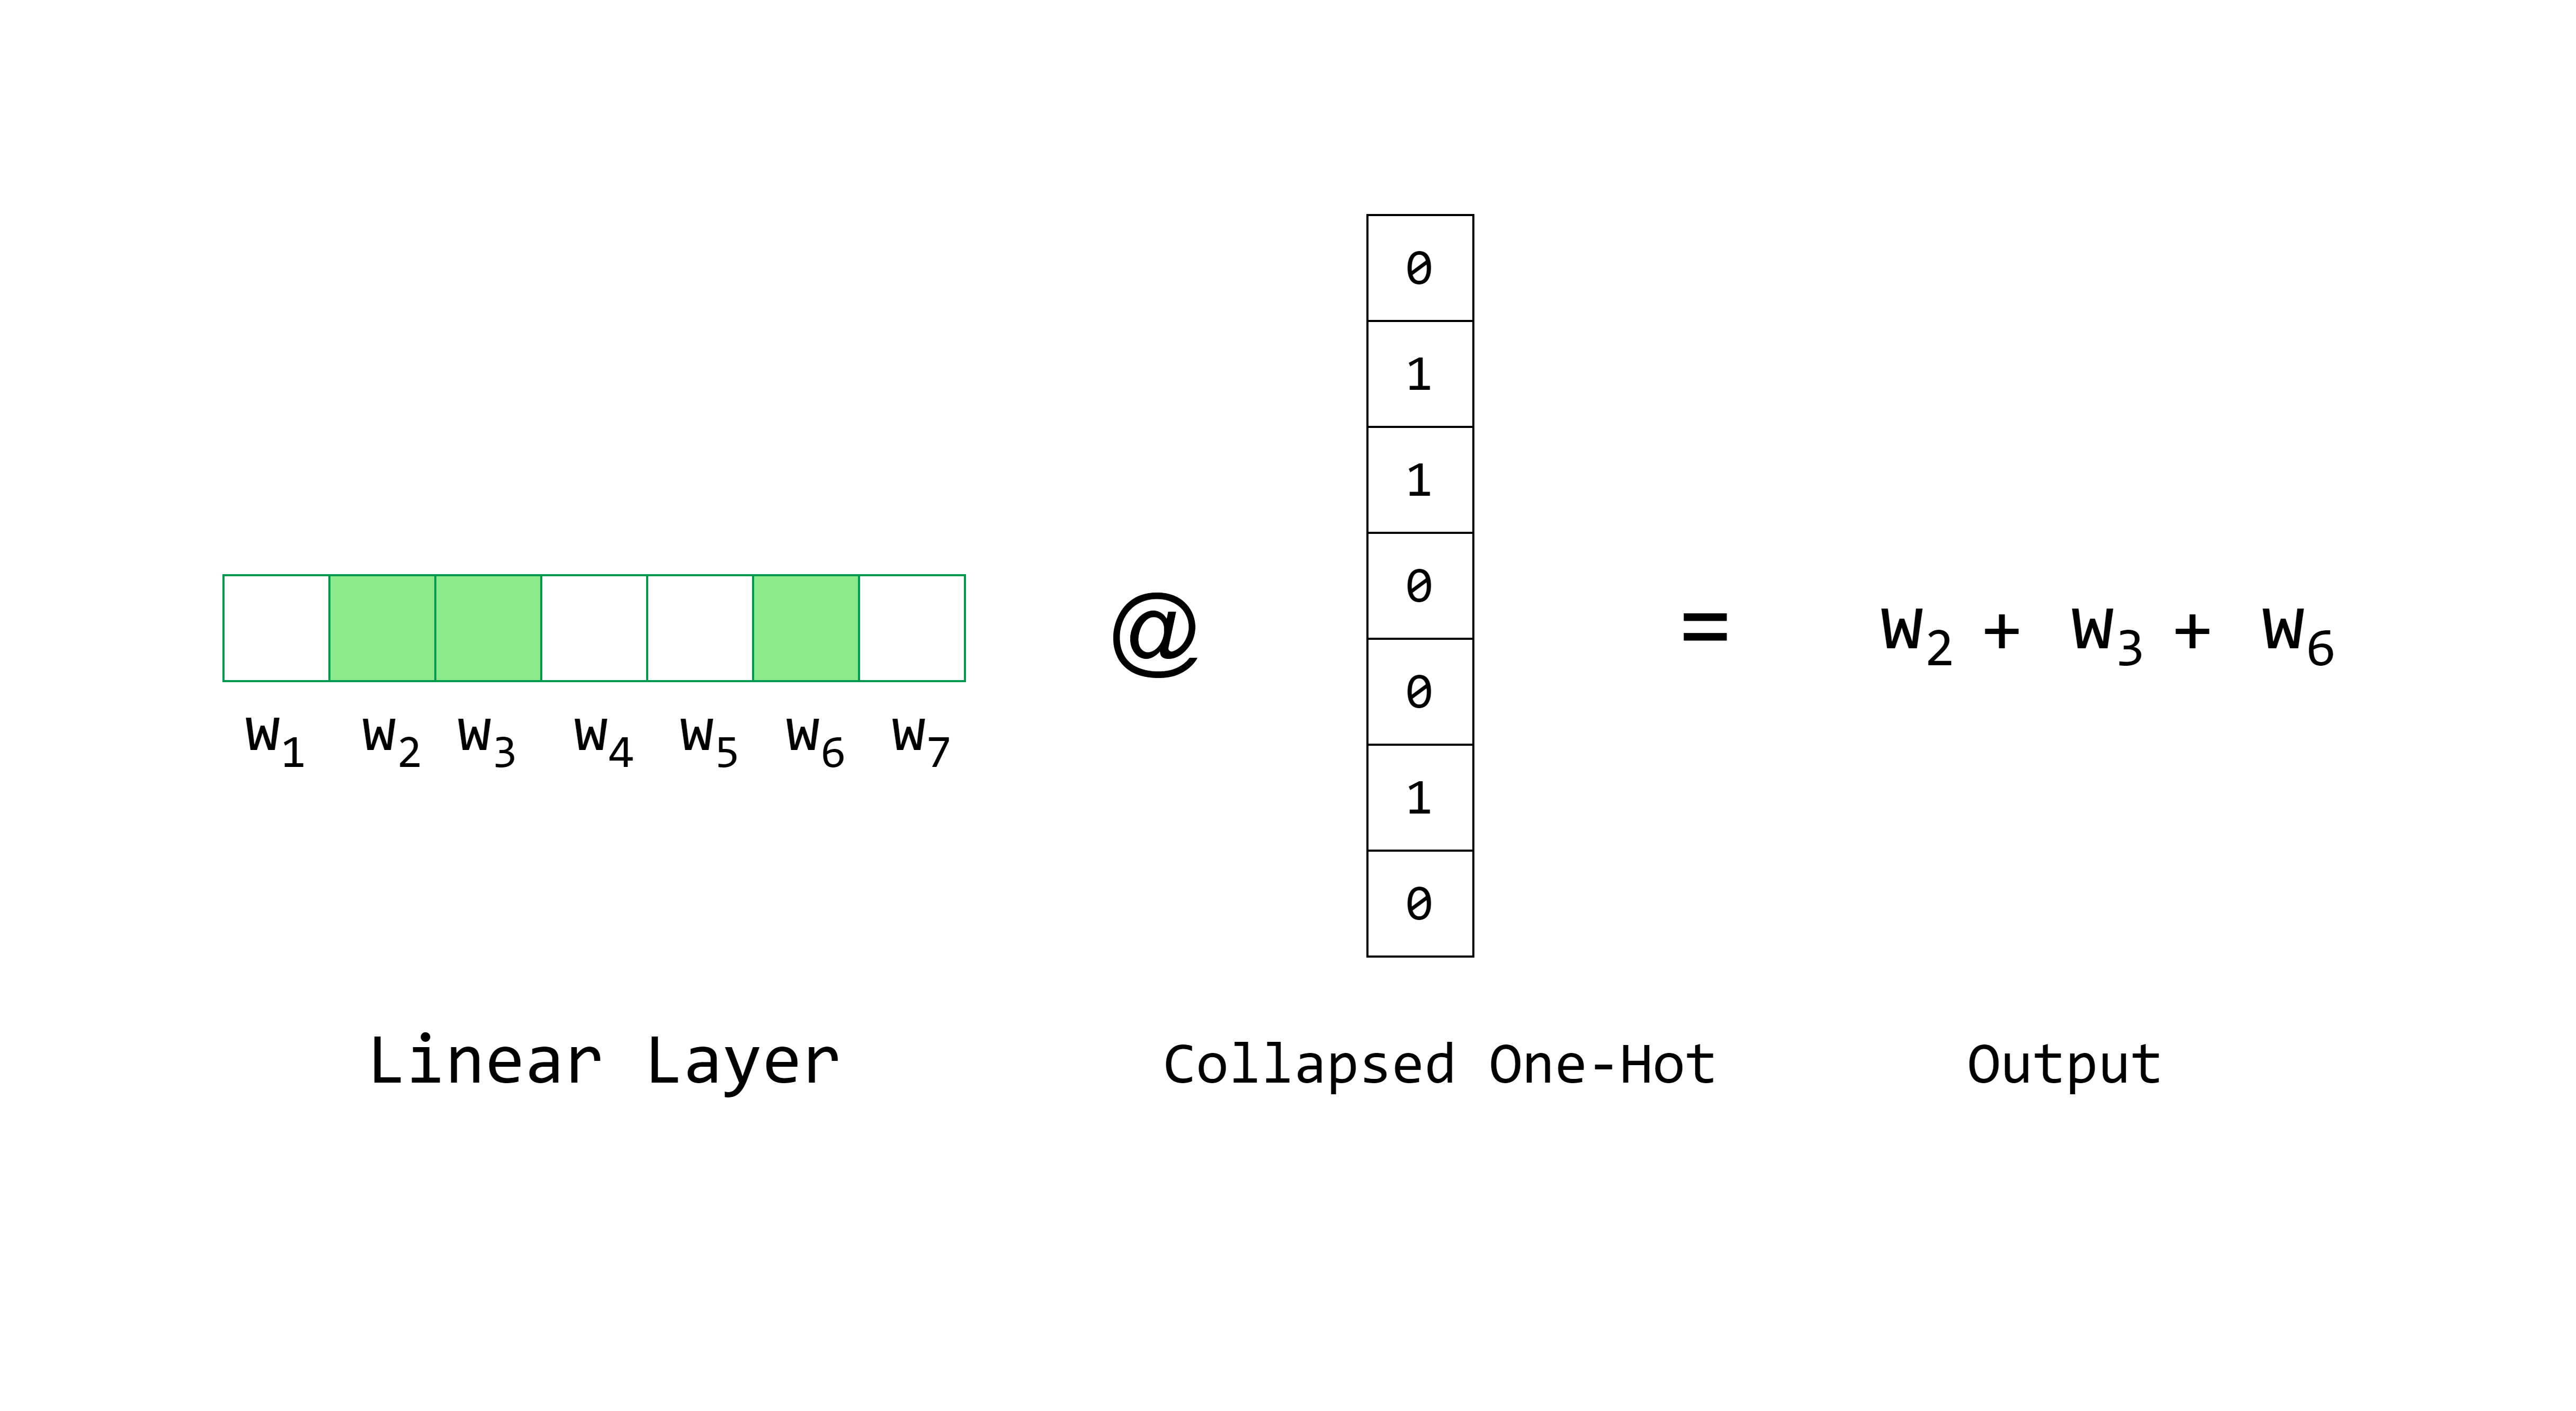

In [98]:
import torch.nn as nn

class Classifier(nn.Module):
    """ 
    A single-layer classifier with sigmoid activation
    
    Args:
        num_features (int): the size of the input feature tensor
    
    """
    def __init__(self, num_features):
        super().__init__()
        self.linear_layer  = nn.Linear(in_features = num_features, out_features = 1)
        self.activation = nn.Sigmoid()
        
    def forward(self, inputs):
        """ Forward pass"""
        # inputs have shape (batch_size, num_features)
        output = self.linear_layer(inputs)
        probabilities = self.activation(output)
        return probabilities

Verify if cuda is available and move the model to the device.

In [99]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Classifier(len(vocabulary)).to(device)

Instantiate Adam optimizer and Binary Cross Entropy loss.

In [100]:
optimizer = torch.optim.Adam(model.parameters())
loss_function = torch.nn.BCELoss()

## <h6 style="text-align: center;"><b>Model Training</b>

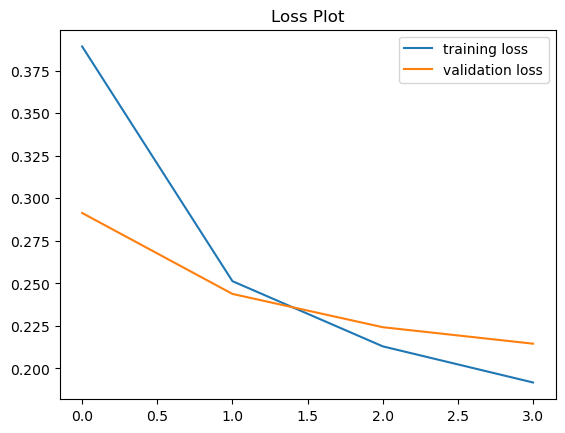

In [103]:
num_epochs = 4
batch_size = 128
loss_dict = defaultdict(list)

for epoch in range(num_epochs):
    
    running_loss = 0
    model.train()
    
    for batch_index, (inputs, targets) in enumerate(train_dataloader, start=1):
        
        # step 0. Fetch a batch of inputs-labels pairs
        inputs, targets = inputs.to(device), targets.to(device)   
        # step 1. Compute the prediction
        predictions = model(inputs).squeeze()
        # step 2. Calculate loss
        loss = loss_function(predictions, targets)
        # step 3. Compute gradients
        loss.backward()
        # step 4. Update parameters using gradients
        optimizer.step()
        # step 5. Reset the gradients to zero
        optimizer.zero_grad() 
        # step 6. reporting
        batch_loss = loss.item()
        running_loss += (batch_loss - running_loss) / batch_index  
        
    loss_dict["training_loss"].append(running_loss)
    
    running_loss = 0
    model.eval()
    
    for batch_index, (inputs, targets) in enumerate(eval_dataloader, start=1):
        
        # step 0. fetch a batch and move inputs and labels to device
        inputs, targets = inputs.to(device), targets.to(device)
        
        # context manager that disables gradient calculation
        with torch.no_grad():
        
            predictions = model(inputs).squeeze()
            loss = loss_function(predictions, targets.to(torch.float))
            # step 6. reporting
            batch_loss = loss.item()
            running_loss += (batch_loss - running_loss) / batch_index  
            
    loss_dict["validation_loss"].append(running_loss)
    
    clear_output()
    plt.plot(loss_dict["training_loss"], label = "training loss")
    plt.plot(loss_dict["validation_loss"], label = "validation loss")
    plt.legend()
    plt.title('Loss Plot')
    plt.show()

## <h6 style="text-align: center;"><b>Model saving</b>

In [ ]:
# save the parameters of your model (without the architecture)
torch.save(model.state_dict(), "classifierYelp.pt")

## <h6 style="text-align: center;"><b>Model evaluation by prediction and weights inspection</b>

In [113]:
def predict_sentiment(review):
    
    vectorized_review = vectorize(review).to(device)
    with torch.no_grad(): 
        probability = model(vectorized_review.view(1, -1))
    
    return "negative" if probability >= 0.5 else "positive" 

In [114]:
train_data.iloc[1].review

' hours , minutes total time for an extremely simple physical . stay away unless you have hours to waste ! ! ! '

In [115]:
predict_sentiment(train_data.iloc[0].review)

'negative'

In [116]:
neurons = model.linear_layer.weight.data.detach()[0].to("cpu")

In [118]:
import itertools
values, indices = torch.sort(neurons)
indices = indices.numpy().tolist()
tokens = vocabulary.lookup_tokens(indices)
print("Influential words in positive reviews:\n", tokens[:10])
print("Influential words in neagative reviews:\n", tokens[::-1][:10])

Influential words in positive reviews:
 ['delicious', 'amazing', 'great', 'fantastic', 'vegas', 'excellent', 'awesome', 'perfect', 'love', 'yummy']
Influential words in neagative reviews:
 ['worst', 'horrible', 'bland', 'mediocre', 'rude', 'terrible', 'awful', 'meh', 'overpriced', 'tasteless']
